### Loading Libraries 

In [33]:
library(corrplot)
library(glmnet)
library(gbm)

Loaded gbm 2.1.8.1



### Read the Data 

In [1]:
path <- "./"
filename <- "Misdemeanor_Data.csv"

In [2]:
# setting to current working directory
setwd(path)

In [3]:
# reading the csv file
data <- read.csv(filename)
head(data, 5)

,County,Year,Misdemeanor.rate.10000,Total.population,Median.age,Male.median.age,Female.median.age,Gender.ratio,Male.PCT,Female.PCT,⋯,Black_African.American.PCT,Hispanic.PCT,Median.household.income,Median.Family.Income,Educ_Below.High.School.Grad_Age18_24,Educ_Below.9th.grade_Age25up,Below.poverty.level.PCT,Unemployment.rate,Winter.TAVG,Summer.TAVG
,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Albany,2010,209.52,304032,38.1,36.4,39.6,93.3,48.3,51.7,⋯,12.1,4.6,56090,76159,7.7,3.1,12.6,7.0,22.45484,61.89000
2,Albany,2011,198.45,303957,38.1,36.6,39.8,93.4,48.3,51.7,⋯,12.3,4.8,57715,78717,7.6,2.9,12.8,6.9,20.38571,62.83429
3,Albany,2012,203.18,304511,38.2,36.6,40.0,93.6,48.3,51.7,⋯,12.6,5.0,59359,80016,7.6,2.6,13.1,7.1,24.10526,65.08889
4,Albany,2013,202.44,305279,38.0,36.5,39.9,93.6,48.4,51.6,⋯,12.8,5.2,59394,81846,7.5,2.5,13.0,6.1,21.34615,63.61842
5,Albany,2014,177.15,306124,37.9,36.5,39.7,93.6,48.4,51.6,⋯,12.7,5.3,59940,82749,6.8,2.4,13.6,4.9,22.89118,60.54167


### Missing Values Analysis

In [4]:
# total number of missing values
count_na <- sum(is.na(data))
print(paste("Total Number of missing values in the dataframe: ", count_na))

[1] "Total Number of missing values in the dataframe:  15"


In [5]:
# total number of missing values in each column
sapply(data, function(col) sum(is.na(col)))

County                                 Year 
                                   0                                    1 
              Misdemeanor.rate.10000                     Total.population 
                                   0                                    0 
                          Median.age                      Male.median.age 
                                   0                                    0 
                   Female.median.age                         Gender.ratio 
                                   0                                    0 
                            Male.PCT                           Female.PCT 
                                   3                                    0 
                 White.Americans.PCT           Black_African.American.PCT 
                                   0                                    0 
                        Hispanic.PCT              Median.household.income 
                                   1                                    3 
                Median.Family.Income Educ_Below.High.School.Grad_Age18_24 
                                   3                                    0 
        Educ_Below.9th.grade_Age25up              Below.poverty.level.PCT 
                                   0                                    1 
                   Unemployment.rate                          Winter.TAVG 
                                   1                                    1 
                         Summer.TAVG 
                                   1

In [6]:
# number of missing values (NAs) for those columns that have NAs
na_columns <- names(data)[sapply(data, function(col) any(is.na(col)))]
na_columns_df <- data.frame(Column=na_columns, count=sapply(data[na_columns], function(col) sum(is.na(col))))

In [7]:
# ratio of Na to total values
na_ratio <- count_na / nrow(data)
print(paste("Ratio of Na values: ", na_ratio))

[1] "Ratio of Na values:  0.0268817204301075"


###  Mean Imputation for Numerical Columns 

In [8]:
D1=data
# for each column in the dataset that has na value
for(col in na_columns){
  # check if the column is numeric
  if(is.numeric(D1[[col]])){
    # replace the numeric column with mean
    D1[[col]][is.na(D1[[col]])] <- mean(D1[[col]], na.rm=TRUE)
  }
}

### Mode Imputation for Categorical Columns 

In [9]:
# for each column in the dataset that has na value
for(col in na_columns){
  # check if the column is categorical
  if(is.factor(D1[[col]]) | is.character(D1[[col]])){
    # replace the numeric column with mode
    D1[[col]][is.na(D1[[col]])] <- mode(D1[[col]],na.rm=TRUE)
  }
}

In [10]:
# categorical columns from the data D1
categorical_cols = names(which(sapply(D1,is.factor) | sapply(D1,is.character)))
# total number of missing values in each column
sapply(D1[categorical_cols], function(col) sum(is.na(col)))

County 
     0

In [11]:
print(paste("Number of columns before dropping county and year: ", ncol(D1)))
# dropping the column County and Year
D2 <- D1[, !(names(D1) %in% c("County", "Year"))]
print(paste("Number of columns after dropping county and year: ", ncol(D2)))

[1] "Number of columns before dropping county and year:  21"
[1] "Number of columns after dropping county and year:  19"


### Correlation Matrix

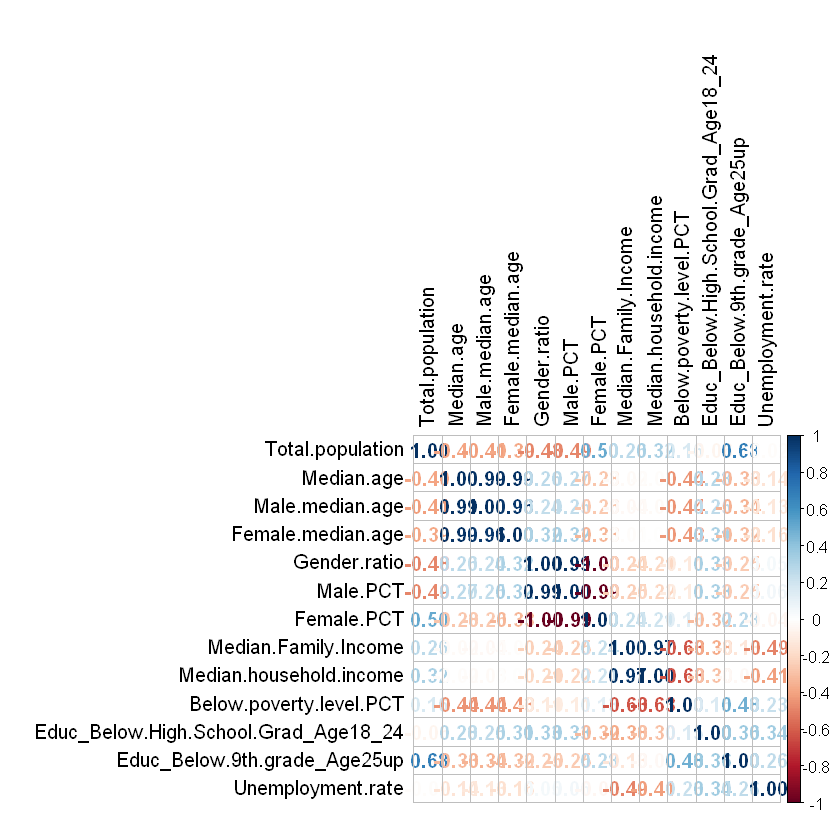

In [13]:
# vector of socio-economics columns
socio_economic_cols <- c("Total.population", "Median.age", "Male.median.age", "Female.median.age",
  "Gender.ratio", "Male.PCT", "Female.PCT", "Median.Family.Income", 
  "Median.household.income", "Below.poverty.level.PCT", 
  "Educ_Below.High.School.Grad_Age18_24", "Educ_Below.9th.grade_Age25up",
  "Unemployment.rate")
# create socio_economic_df dataframe containing socio-economics columns
socio_economic_df <- D2[, socio_economic_cols]
# correlation of socio-economics columns
corr_socio_enconomic = cor(socio_economic_df)
# correlation matrix plot
corrplot(corr_socio_enconomic, method = 'number', tl.col="black")

### Boxplot 

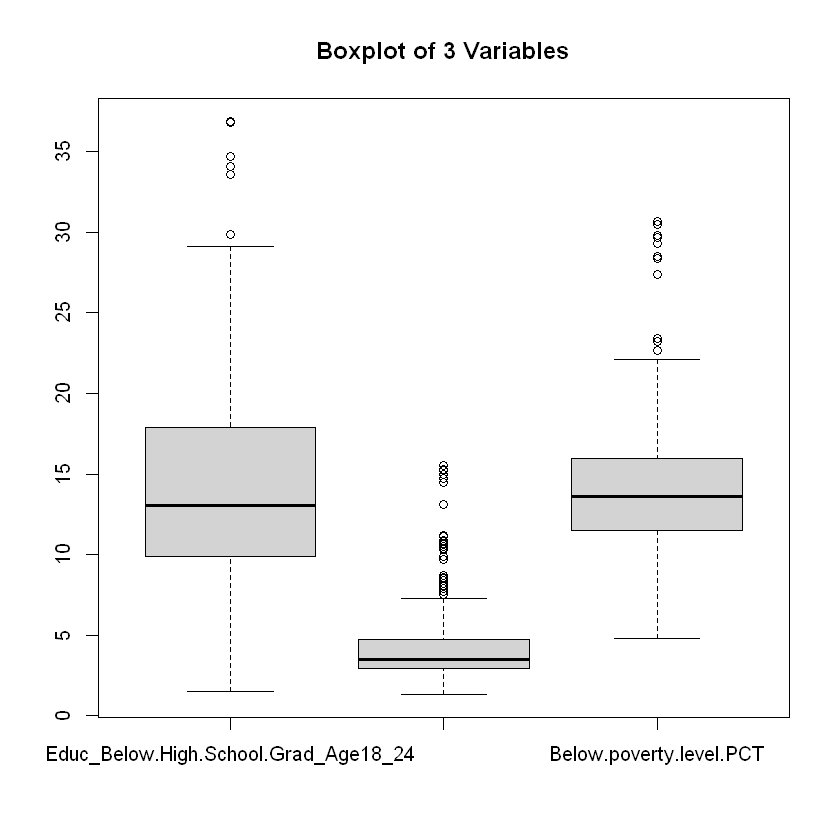

In [14]:
# 3 variables from the dataset
three_variables <- list(D2$Educ_Below.High.School.Grad_Age18_24, 
                        D2$Educ_Below.9th.grade_Age25up, 
                        D2$Below.poverty.level.PCT)
# vector of names
three_variables_names <- c("Educ_Below.High.School.Grad_Age18_24", 
                           "Educ_Below.9th.grade_Age25up", "Below.poverty.level.PCT")
# boxplot of 3 features
boxplot(three_variables, names=three_variables_names, 
        main="Boxplot of 3 Variables")

### Correlation Matrix 

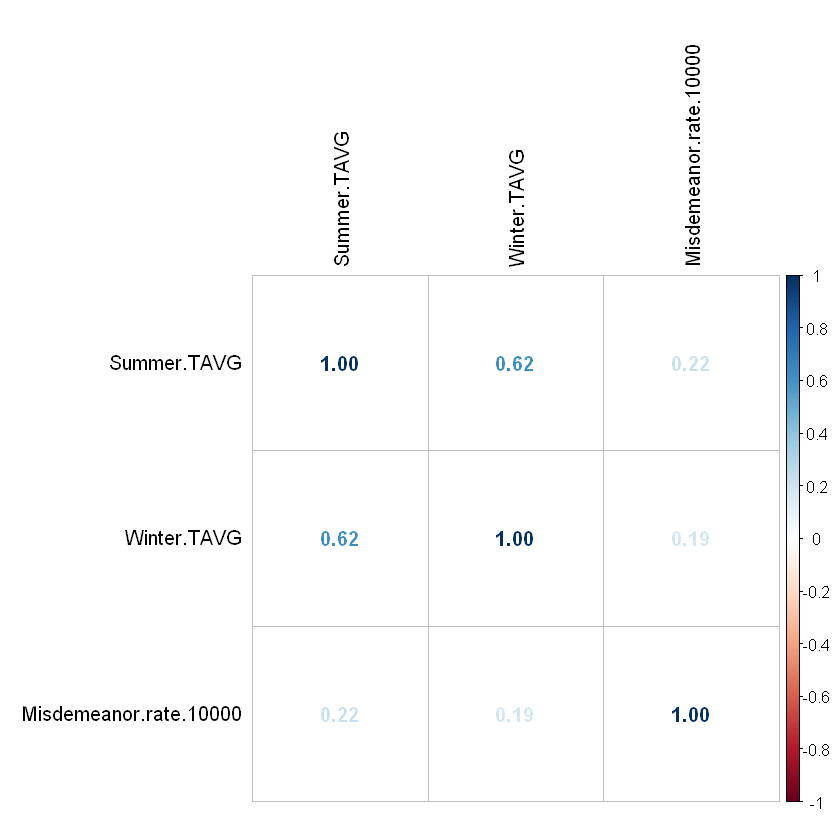

In [15]:
# vector of climate variables
climate_var <- c("Summer.TAVG", "Winter.TAVG")
# target variable
target_var = D2$Misdemeanor.rate.10000
# correlation matrix
corr_climate_var = cor(D2[, c(climate_var, "Misdemeanor.rate.10000")])
# correlation matrix plot 
corrplot(corr_climate_var, method = "number", tl.col="black")

### Train-Test Split 

In [16]:
# random number to reproduce
set.seed(123)
# random shuffle the data and splitting the data into 70% train and 30% test set
train_index <- sample(nrow(D2), nrow(D2)*0.70)
train_data <- D2[train_index,]
test_data <- D2[-train_index,]
print(paste("Trainset Size: ", nrow((train_data))))
print(paste("Testset Size: ", nrow((test_data))))

[1] "Trainset Size:  390"
[1] "Testset Size:  168"


### Linear Regression

In [17]:
# Linear regression model 
linear_model <- lm(Misdemeanor.rate.10000 ~ ., data = train_data)
# summary of the regression model fit
summary(linear_model)


Call:
lm(formula = Misdemeanor.rate.10000 ~ ., data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-125.062  -20.512   -3.062   17.254  167.924 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          -1.268e+04  2.128e+03  -5.958 5.94e-09 ***
Total.population                     -7.883e-07  8.297e-06  -0.095 0.924360    
Median.age                           -3.038e+01  1.268e+01  -2.397 0.017022 *  
Male.median.age                       1.870e+01  6.126e+00   3.053 0.002432 ** 
Female.median.age                     1.334e+01  7.262e+00   1.837 0.067044 .  
Gender.ratio                          3.682e+01  6.328e+00   5.818 1.29e-08 ***
Male.PCT                              1.092e+01  9.205e+00   1.186 0.236308    
Female.PCT                            1.646e+02  2.755e+01   5.976 5.38e-09 ***
White.Americans.PCT                   1.112e+00  7.199e-01   1.545 0.123161    
Black_African.

In [18]:
# predict using linear regression model on train set
lm_train_preds <- predict(linear_model, newx = as.matrix(train_data[, -1]))

In [19]:
# evaluate the model on train set
lm_train_r2 <- cor(train_data$Misdemeanor.rate.10000, lm_train_preds)^2
lm_train_rmse <- sqrt(mean((train_data$Misdemeanor.rate.10000 - lm_train_preds)^2))
lm_train_adjusted_r2 <- 1 - ((1 - lm_train_r2) * (nrow(train_data) - 1)) / (nrow(train_data) - 1 - 1)
print(paste0("Train RMSE value : ", lm_train_rmse))
print(paste0("Train R-Squared : ", lm_train_r2))
print(paste0("Train Adjusted R-Squared : ", lm_train_adjusted_r2))

[1] "Train RMSE value : 31.8277353296553"
[1] "Train R-Squared : 0.600177743021804"
[1] "Train Adjusted R-Squared : 0.599147273287324"


In [20]:
# Predict test data using regression model
test_data$predicted_Misdemeanor.rate.10000 <- predict(linear_model, newdata = test_data)

In [21]:
# r squared for model
lm_test_r2 <- 1 - (sum((test_data$Misdemeanor.rate.10000 - test_data$predicted_Misdemeanor.rate.10000)^2) / 
                     sum((test_data$Misdemeanor.rate.10000 - mean(test_data$Misdemeanor.rate.10000))^2))
# root mean square error for model
lm_test_rmse <- sqrt(mean((test_data$Misdemeanor.rate.10000 - test_data$predicted_Misdemeanor.rate.10000)^2))
lm_test_adjusted_r2 <- 1 - ((1 - lm_test_r2) * (nrow(test_data) - 1)) / (nrow(test_data) - 1 - 1)
print(paste0("Test RMSE value : ", lm_test_rmse))
print(paste0("Test R-Squared : ", lm_test_r2))
print(paste0("Test Adjusted R-Squared : ", lm_test_adjusted_r2))
test_data <- test_data[, !(names(test_data) %in% c("predicted_Misdemeanor.rate.10000"))]

[1] "Test RMSE value : 36.5692675322362"
[1] "Test R-Squared : 0.565478689067574"
[1] "Test Adjusted R-Squared : 0.562861090808945"


### Ridge Regression

In [23]:
# best lambda using 10 fold cross validation for Ridge regression
cv_ridge <- cv.glmnet(x = as.matrix(train_data[, -1]), 
                      y = train_data$Misdemeanor.rate.10000, 
                      alpha = 0, nfolds = 10)
best_lambda_ridge <- cv_ridge$lambda.min
print(paste0("Best Lambda Value for Ridge Regression = ", best_lambda_ridge))

[1] "Best Lambda Value for Ridge Regression = 2.69111109260953"


In [24]:
# fit ridge regression with the choose best lambda
ridge_model <- glmnet(x = as.matrix(train_data[, -1]), 
                      train_data$Misdemeanor.rate.10000, 
                      alpha = 0, lambda = best_lambda_ridge)

# predict using ridge regression model on train set
ridge_train_preds <- predict(ridge_model, newx = as.matrix(train_data[, -1]))

In [25]:
# evaluate the model on train set
ridge_train_r2 <- cor(train_data$Misdemeanor.rate.10000, ridge_train_preds)^2
ridge_train_rmse <- sqrt(mean((train_data$Misdemeanor.rate.10000 - ridge_train_preds)^2))
ridge_train_adjusted_r2 <- 1 - ((1 - ridge_train_r2) * (nrow(train_data) - 1)) / (nrow(train_data) - 1 - 1)
print(paste0("Train RMSE value : ", ridge_train_rmse))
print(paste0("Train R-Squared : ", ridge_train_r2))
print(paste0("Train Adjusted R-Squared : ", ridge_train_adjusted_r2))

[1] "Train RMSE value : 34.0344856343159"
[1] "Train R-Squared : 0.544142257303633"
[1] "Train Adjusted R-Squared : 0.54296736621421"


In [26]:
# predict using ridge regression model on test set
ridge_test_preds <- predict(ridge_model, newx = as.matrix(test_data[, -1]))
# evaluate the model on test set
ridge_test_r2 <- cor(test_data$Misdemeanor.rate.10000, ridge_test_preds)^2
ridge_test_rmse <- sqrt(mean((test_data$Misdemeanor.rate.10000 - ridge_test_preds)^2))
ridge_test_adjusted_r2 <- 1 - ((1 - ridge_test_r2) * (nrow(test_data) - 1)) / (nrow(test_data) - 1 - 1)
print(paste0("Test RMSE value : ", ridge_test_rmse))
print(paste0("Test R-Squared : ", ridge_test_r2))
print(paste0("Test Adjusted R-Squared : ", ridge_test_adjusted_r2))

[1] "Test RMSE value : 38.0638059695173"
[1] "Test R-Squared : 0.557193800838173"
[1] "Test Adjusted R-Squared : 0.554526293614307"


### Lasso Regression 

In [27]:
# best lambda using cross validation for Lasso regression
cv_lasso <- cv.glmnet(x = as.matrix(train_data[, -1]), 
                      y = train_data$Misdemeanor.rate.10000, 
                      alpha = 1, nfolds = 10)
best_lambda_lasso <- cv_lasso$lambda.min
print(paste0("Best Lambda Value for Lasso Regression = ", best_lambda_lasso))

[1] "Best Lambda Value for Lasso Regression = 0.00470279306191087"


In [28]:
# fit lasso regression with the choose best lambda
lasso_model <- glmnet(x = as.matrix(train_data[, -1]), 
                      y = train_data$Misdemeanor.rate.10000, 
                      alpha = 1, lambda = best_lambda_lasso)
# predict using lasso regression model on train set
lasso_train_preds <- predict(lasso_model, newx = as.matrix(train_data[, -1]))

In [29]:
# evaluate the model on train set
lasso_train_r2 <- cor(train_data$Misdemeanor.rate.10000, lasso_train_preds)^2
lasso_train_rmse <- sqrt(mean((train_data$Misdemeanor.rate.10000 - lasso_train_preds)^2))
lasson_train_adjusted_r2 <- 1 - ((1 - lasso_train_r2) * (nrow(train_data) - 1)) / (nrow(train_data) - 1 - 1)
print(paste0("Train RMSE value : ", lasso_train_rmse))
print(paste0("Train R-Squared : ", lasso_train_r2))
print(paste0("Train Adjusted R-Squared : ", lasson_train_adjusted_r2))

[1] "Train RMSE value : 31.8357485169419"
[1] "Train R-Squared : 0.599991064381043"
[1] "Train Adjusted R-Squared : 0.598960113516046"


In [30]:
# predict using lasso regression model on test set
lasso_test_preds <- predict(lasso_model, newx = as.matrix(test_data[, -1]))
# evaluate the model on test set
lasso_test_r2 <- cor(test_data$Misdemeanor.rate.10000, lasso_test_preds)^2
lasso_test_rmse <- sqrt(mean((test_data$Misdemeanor.rate.10000 - lasso_test_preds)^2))
lasso_test_adjusted_r2 <- 1 - ((1 - lasso_test_r2) * (nrow(test_data) - 1)) / (nrow(test_data) - 1 - 1)
print(paste0("Test RMSE value : ", lasso_test_rmse))
print(paste0("Test R-Squared : ", lasso_test_r2))
print(paste0("Test Adjusted R-Squared : ", lasso_test_adjusted_r2))

[1] "Test RMSE value : 36.512742328602"
[1] "Test R-Squared : 0.578525843529806"
[1] "Test Adjusted R-Squared : 0.575986842587214"


### squared bias versus 𝝀 and variance versus 𝝀.

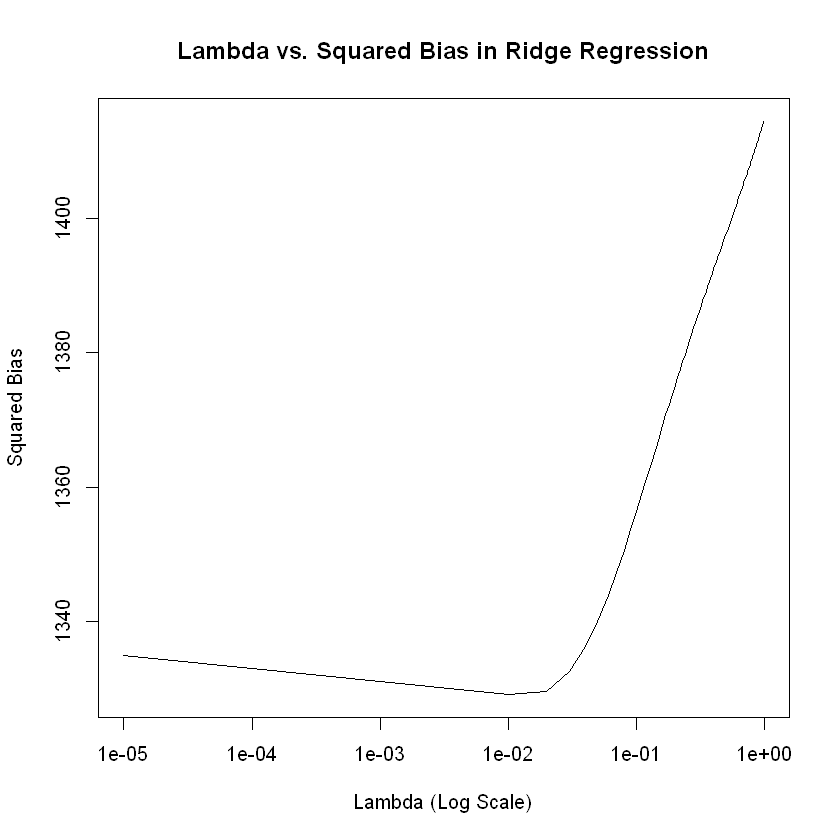

In [31]:
#random seed for reproducibility
set.seed(123)

# vector of lambda values 
lambda_values <- seq(0.00001, 1, by = 0.01)

# vectors to keep track of lambda values and squared bias
lambda_list <- c()
sqr_bias_list <- c()

for (lambda in lambda_values){
  # A ridge regression model 
  ridge_model <- glmnet(x = as.matrix(train_data[, -1]), 
                        train_data$Misdemeanor.rate.10000, 
                        alpha = 0, lambda = lambda)
  
  # Squared bias between the predicted values and actual values.
  y_predictions = predict(ridge_model, s = lambda, newx = as.matrix(test_data[, -1]))
  squared_bias <- mean((y_predictions - test_data$Misdemeanor.rate.10000)^2)
  
  # Store lambda and squared bias
  lambda_list <- c(lambda_list, lambda)
  sqr_bias_list <- c(sqr_bias_list, squared_bias)
}

plot(lambda_list, sqr_bias_list, type = "l", log = "x", 
     xlab = "Lambda (Log Scale)", ylab = "Squared Bias",
     main = "Lambda vs. Squared Bias in Ridge Regression")

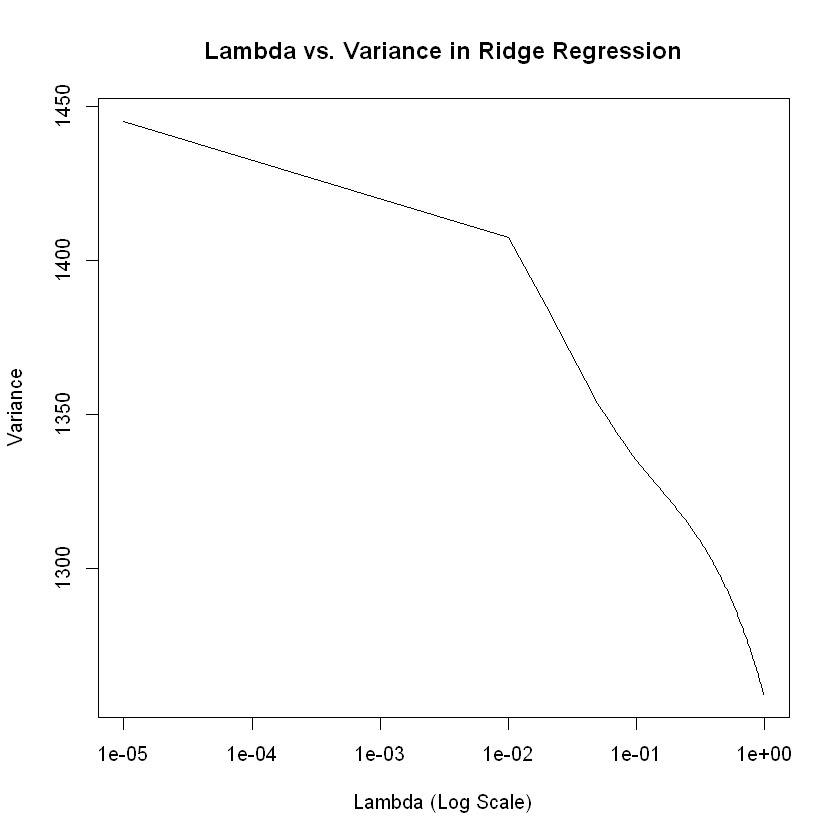

In [32]:
# vector of lambda values 
lambda_values <- seq(0.00001, 1, by = 0.01)

# vectors to keep track of lambda values and squared bias
lambda_list <- c()
variance_list <- c()

for (lambda in lambda_values) {
  # A ridge regression model 
  ridge_model <- glmnet(x = as.matrix(train_data[, -1]), 
                        train_data$Misdemeanor.rate.10000, 
                        alpha = 0, lambda = lambda)
  
  # Squared bias between the predicted values and actual values.
  y_predictions = predict(ridge_model, s = lambda, newx = as.matrix(test_data[, -1]))
  variance <- var(y_predictions)
  
  # Store lambda and variance
  lambda_list <- c(lambda_list, lambda)
  variance_list <- c(variance_list, variance)
}
  
plot(lambda_list, variance_list, type = "l", log = "x", 
      xlab = "Lambda (Log Scale)", ylab = "Variance",
      main = "Lambda vs. Variance in Ridge Regression")

### Adaboost 

In [34]:
# Train the AdaBoost model with gbm
set.seed(123) # For reproducibility
gbm_model <- gbm(as.formula(paste("Misdemeanor.rate.10000", "~ .")), data=train_data, 
                 distribution="gaussian", n.trees=500, shrinkage=0.01, interaction.depth=3)

# predict using gbm regression model on train set
gbm_train_preds <- predict(gbm_model, newx = as.matrix(train_data[, -1]))

Using 500 trees...




In [35]:
# evaluate the model on train set
gbm_train_r2 <- cor(train_data$Misdemeanor.rate.10000, gbm_train_preds)^2
gbm_train_rmse <- sqrt(mean((train_data$Misdemeanor.rate.10000 - gbm_train_preds)^2))
gbm_train_adjusted_r2 <- 1 - ((1 - gbm_train_r2) * (nrow(train_data) - 1)) / (nrow(train_data) - 1 - 1)
print(paste0("Train RMSE value : ", gbm_train_rmse))
print(paste0("Train R-Squared : ", gbm_train_r2))
print(paste0("Train Adjusted R-Squared : ", gbm_train_adjusted_r2))

[1] "Train RMSE value : 20.533405469473"
[1] "Train R-Squared : 0.851289855953244"
[1] "Train Adjusted R-Squared : 0.850906582386114"


In [36]:
# Predict test data using gbm model
test_data$predicted_Misdemeanor.rate.10000 <- predict(gbm_model, newdata = test_data, n.trees=500)

In [37]:
# r squared for model
gbm_test_r2 <- 1 - (sum((test_data$Misdemeanor.rate.10000 - test_data$predicted_Misdemeanor.rate.10000)^2) / 
                     sum((test_data$Misdemeanor.rate.10000 - mean(test_data$Misdemeanor.rate.10000))^2))
# root mean square error for model
gbm_test_rmse <- sqrt(mean((test_data$Misdemeanor.rate.10000 - test_data$predicted_Misdemeanor.rate.10000)^2))
gbm_test_adjusted_r2 <- 1 - ((1 - gbm_test_r2) * (nrow(test_data) - 1)) / (nrow(test_data) - 1 - 1)
print(paste0("Test RMSE value : ", gbm_test_rmse))
print(paste0("Test R-Squared : ", gbm_test_r2))
print(paste0("Test Adjusted R-Squared : ", gbm_test_adjusted_r2))
test_data <- test_data[, !(names(test_data) %in% c("predicted_Misdemeanor.rate.10000"))]

[1] "Test RMSE value : 26.3486953409138"
[1] "Test R-Squared : 0.774421975179797"
[1] "Test Adjusted R-Squared : 0.77306307141582"
